In [1]:
import pandas as pd
import numpy as np
import itertools

import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchmetrics.classification import F1Score, Accuracy
from torch.optim import Optimizer, SGD
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from keras.datasets import mnist
from keras import backend as k

import time
import matplotlib.pyplot as plt

CUDA initialization

In [2]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

Is CUDA supported by this system? True
CUDA version: 11.6


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

AMP Module and Layer Configuration for Torch

In [4]:
# This is an experimental Torch optimizer downloaded from here: https://github.com/hiyouga/AMP-Regularizer
class AMP(Optimizer):
    """
    Implements adversarial model perturbation.

    Args:
        params (iterable): iterable of trainable parameters
        lr (float): learning rate for outer optimization
        epsilon (float): perturbation norm ball radius
        inner_lr (float, optional): learning rate for inner optimization (default: 1)
        inner_iter (int, optional): iteration number for inner optimization (default: 1)
        base_optimizer (class, optional): basic optimizer class (default: SGD)
        **kwargs: keyword arguments passed to the `__init__` method of `base_optimizer`

    Example:
        >>> optimizer = AMP(model.parameters(), lr=0.1, eps=0.5, momentum=0.9)
        >>> for inputs, targets in dataset:
        >>>     def closure():
        >>>         optimizer.zero_grad()
        >>>         outputs = model(inputs)
        >>>         loss = loss_fn(outputs, targets)
        >>>         loss.backward()
        >>>         return outputs, loss
        >>>     outputs, loss = optimizer.step(closure)
    """

    def __init__(self, params, lr, epsilon, inner_lr=1, inner_iter=1, base_optimizer=SGD, **kwargs):
        if epsilon < 0.0:
            raise ValueError(f"Invalid epsilon: {epsilon}")
        if inner_lr < 0.0:
            raise ValueError(f"Invalid inner lr: {inner_lr}")
        if inner_iter < 0:
            raise ValueError(f"Invalid inner iter: {inner_iter}")
        defaults = dict(lr=lr, epsilon=epsilon, inner_lr=inner_lr, inner_iter=inner_iter, **kwargs)
        super(AMP, self).__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups, lr=lr, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def step(self, closure=None):
        if closure is None:
            raise ValueError('Adversarial model perturbation requires closure, but it was not provided')
        closure = torch.enable_grad()(closure)
        outputs, loss = map(lambda x: x.detach(), closure())
        for i in range(self.defaults['inner_iter']):
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        if i == 0:
                            self.state[p]['dev'] = torch.zeros_like(p.grad)
                        dev = self.state[p]['dev'] + group['inner_lr'] * p.grad
                        clip_coef = group['epsilon'] / (dev.norm() + 1e-12)
                        dev = clip_coef * dev if clip_coef < 1 else dev
                        p.sub_(self.state[p]['dev']).add_(dev) # update "theta" with "theta+delta"
                        self.state[p]['dev'] = dev
            closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.sub_(self.state[p]['dev']) # restore "theta" from "theta+delta"
        self.base_optimizer.step()
        return outputs, loss

# Function to instantiate the CNN.
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=5, padding = 2),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Dropout(0.25),
      nn.Conv2d(32, 64, kernel_size=5, padding = 2),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Dropout(0.25),
      nn.Conv2d(64, 128, kernel_size=3, padding = 2),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Dropout(0.25),
      nn.Flatten(),
      nn.Linear(2048,256),
      nn.ReLU(),
      nn.Linear(256, 64),
      nn.ReLU(),    
      nn.Linear(64, 10),
      nn.Softmax(dim=1),      
    )


  def forward(self, x):
    return self.layers(x)

# Helper function to convert numpy arrays (input) to Torch tensors.
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32)).to(device)
        self.y = torch.from_numpy(y.astype(np.int64)).to(device)
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

Function to Train and Test CNN

In [9]:
# This calls the Torch CNN to run predictions on the provided data.
def CNN_fit_predict(x_train, y_train, x_test, y_test):

    X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42, stratify=y_train)

    torch.manual_seed(42)

    # Data Loading
    train_data = Data(X_train, np.array(Y_train))
    val_data= Data(X_val, np.array(Y_val))
    test_data = Data(x_test, np.array(y_test))

    train_loader = DataLoader(dataset=train_data, batch_size=1024, shuffle=True)
    valid_loader = DataLoader(dataset=val_data, batch_size=1024, shuffle=False)
    test_loader = DataLoader(dataset=test_data, batch_size=1024, shuffle=False)

    # Instantiate CNN and configure it to use CUDA
    cnn = CNN()
    cnn = cnn.to(device)

     # Set up loss function, optimizer, and adaptive learning rate
    loss_function = nn.CrossEntropyLoss()
    optimizer = AMP(cnn.parameters(), lr=0.1, epsilon=0.75, momentum=0.95, nesterov=True, inner_lr=1,base_optimizer=torch.optim.SGD)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.5,mode='min', min_lr=0.000001, patience=5, threshold=0.00000001)
  
    num_epochs = 100
    best_val = 10000000
    best_model_wts = None

    # Run the CNN
    for epoch in range(num_epochs):

        start = time.time()

        train_loss = 0.0
        y_predT = []
        y_trn = []
        cnn.train()
        for X, y in train_loader:
            # AMP needs a closure to run properly
            def closure():
                optimizer.zero_grad()
                outputs = cnn(X)
                loss = loss_function(outputs, y)
                loss.backward()

                return outputs, loss


            outputs, loss = optimizer.step(closure)
            train_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            y_predT.append(predicted)
            y_trn.append(y.cpu())

        cnn.eval()
        valid_loss = 0.0
        y_predV = []
        y_vl = []

        with torch.no_grad():
            # AMP needs a closure to run properly
            for X, y in valid_loader:
                def closure():
                    optimizer.zero_grad()
                    outputs = cnn(X)
                    loss = loss_function(outputs, y)
                    loss.backward()

                    return outputs, loss

                outputs, loss = optimizer.step(closure)
                valid_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1).cpu().detach().numpy()
                y_predV.append(predicted)
                y_vl.append(y.cpu())

        # Get epoch time
        end = time.time()
        total_time = end - start

        # calculate losses/accuracy and print scores. Also save best weights based on validation loss.
        total_training_loss = train_loss / len(train_loader)
        total_validation_loss = valid_loss / len(valid_loader)

        y_predT = list(itertools.chain(*y_predT))
        y_trn = list(itertools.chain(*y_trn))

        y_predV = list(itertools.chain(*y_predV))
        y_vl = list(itertools.chain(*y_vl))

        tf1 = accuracy_score(y_trn, y_predT)
        vf1 = accuracy_score(y_vl, y_predV)

        if total_validation_loss < best_val:
            best_val = total_validation_loss
            best_model_wts = copy.deepcopy(cnn.state_dict())

        print(f"Epoch {epoch+1} ({round(total_time, 2):.2f}s) => Train Loss: {round(total_training_loss,5):.5f} \t Train Accuracy: {round(tf1,5):.5f} \t Validation Loss: {round(total_validation_loss,5):.5f} \t Validation Accuracy: {round(vf1,5):.5f} \t Learning Rate: {optimizer.param_groups[0]['lr']}")
        scheduler.step(total_validation_loss)

    # Model saves the best weights, as determined by the lowest validation loss.
    cnn.load_state_dict(best_model_wts)

    # Predict on test set

    cnn.eval()
    
    y_predTest = []
    y_test = []
    with torch.no_grad():
        for X, y in test_loader:
            outputs = cnn(X)
            predicted = torch.argmax(outputs, dim=1).cpu().detach().numpy()
            y_predTest.append(predicted)
            y_test.append(y.cpu())

    y_predTest = list(itertools.chain(*y_predTest))
    y_test = list(itertools.chain(*y_test))

    print(f"Test Accuracy: {accuracy_score(y_test, y_predTest)}")

    return

Load and Preprocess MNIST

In [6]:
# Load MNIST from keras.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

"""
Code for converting dataset to machine-readable format adapted from here: 
https://www.geeksforgeeks.org/applying-convolutional-neural-network-on-mnist-dataset/
"""

# Reshape arrays and convert to float.
img_rows, img_cols=28, 28
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Convert to grayscale.
x_train /= 255
x_test /= 255

Show Some Examples

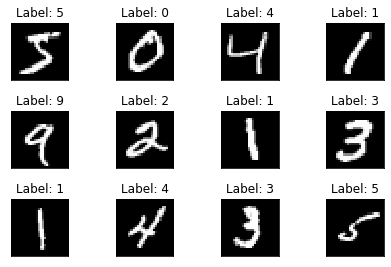

In [7]:
fig = plt.figure()
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

Train the CNN and get Testing Results

In [10]:
CNN_fit_predict(x_train, y_train, x_test, y_test)

Epoch 1 (7.55s) => Train Loss: 2.30233 	 Train Accuracy: 0.10681 	 Validation Loss: 2.30183 	 Validation Accuracy: 0.11233 	 Learning Rate: 0.1
Epoch 2 (7.26s) => Train Loss: 2.30075 	 Train Accuracy: 0.11904 	 Validation Loss: 2.29692 	 Validation Accuracy: 0.18542 	 Learning Rate: 0.1
Epoch 3 (7.44s) => Train Loss: 2.22338 	 Train Accuracy: 0.26050 	 Validation Loss: 2.07036 	 Validation Accuracy: 0.43175 	 Learning Rate: 0.1
Epoch 4 (7.38s) => Train Loss: 1.90966 	 Train Accuracy: 0.55092 	 Validation Loss: 1.80466 	 Validation Accuracy: 0.65183 	 Learning Rate: 0.1
Epoch 5 (7.21s) => Train Loss: 1.77888 	 Train Accuracy: 0.67719 	 Validation Loss: 1.71321 	 Validation Accuracy: 0.75092 	 Learning Rate: 0.1
Epoch 6 (7.26s) => Train Loss: 1.63374 	 Train Accuracy: 0.83144 	 Validation Loss: 1.59113 	 Validation Accuracy: 0.86842 	 Learning Rate: 0.1
Epoch 7 (7.44s) => Train Loss: 1.59161 	 Train Accuracy: 0.86883 	 Validation Loss: 1.56480 	 Validation Accuracy: 0.90100 	 Learning Ra